In [273]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Import

In [193]:
price_vol = pd.read_csv("price_vol.csv", index_col=[0])
news_data = pd.read_csv("btc_eth.csv", index_col=[0])

In [194]:
btc_price = price_vol[['BTC-close']].shift(1)
btc_news = news_data[['BTC']]

In [195]:
btc_price.index = pd.to_datetime(btc_price.index).tz_convert(None)
btc_news.index = pd.to_datetime(btc_news.index)

In [196]:
data = btc_news.merge(btc_price, how = 'inner', left_index=True, right_index=True)

In [197]:
def joinStr(df):
    lists = eval(df[0])
    if(lists[1]):
        return ' '.join(lists[1])
    return np.nan

In [198]:
data['btc_summary'] = data.apply(lambda x : joinStr(x), axis=1)
data['returns'] = data['BTC-close'].pct_change().shift(-1)
data['class'] = data['returns'] > 0
data = data.iloc[:-1, :]

In [200]:
nonewsdate = data[data.isna().any(axis = 1)].index

In [201]:
newsdate = data[~data.isna().any(axis = 1)].index

In [206]:
train_data = data[~data.isna().any(axis = 1)][['btc_summary', 'class']]

In [208]:
train_data.columns = ['text', 'class']

In [215]:
train_data1 = train_data.copy()

# Data Processing

In [213]:
def dataProcess(df):
    processed_data = []
    for text, cls in zip(df['text'], df['class']):
        doc = re.sub('[^A-Za-z]', ' ', text) # Remove non alphabetic characters
        doc = word_tokenize(doc.lower()) # Transform to lower case and word tokenization
        doc = [w for w in doc if w not in stopwords.words('english') ] # Remove stop words in English
        stemmer = PorterStemmer() # Stemming words
        doc = [stemmer.stem(w) for w in doc] # Stemming words
        doc_string = " ".join(doc) # Create string for CountVectorizer use in the future
        processed_data.append(doc_string)
        
    df['text'] = processed_data    
    

In [218]:
dataProcess(train_data1)

In [257]:
train_data1['class'] = train_data1['class'].map({True:'positive', False:'negative'})

In [259]:
n = train_data1.shape[0]
percent = 0.8
X_train, X_test = train_data1.iloc[0 : int(n*percent), 0], train_data1.iloc[int(n*percent):, 0]
y_train, y_test = train_data1.iloc[0 : int(n*percent), 1], train_data1.iloc[int(n*percent):, 1]

In [296]:
backtest = train_data1.iloc[int(n*percent):, :]

# Model

In [285]:
# Limit the features to 500 so we only use the most frequent 500 words
pipeline = Pipeline([('CountVectorizer', CountVectorizer(max_features=10000)), 
                     ('MNB', MultinomialNB())])

In [286]:
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

## Train Data

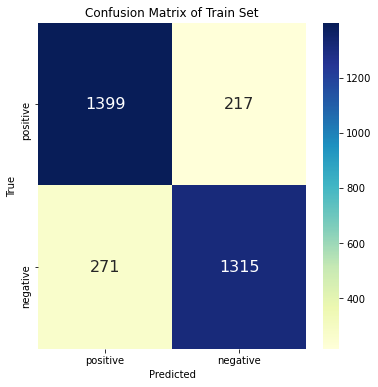

In [287]:
cm_train = confusion_matrix(y_train, y_pred_train, labels=['positive', 'negative'])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_train, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Train Set')

In [288]:
print(classification_report(y_train, y_pred_train, labels = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.84      0.87      0.85      1616
    negative       0.86      0.83      0.84      1586

    accuracy                           0.85      3202
   macro avg       0.85      0.85      0.85      3202
weighted avg       0.85      0.85      0.85      3202



## Test Data

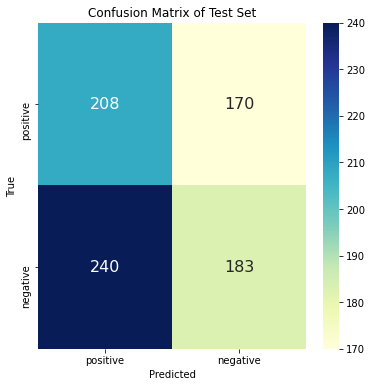

In [289]:
cm_test = confusion_matrix(y_test, y_pred_test, labels = ['positive', 'negative'])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [290]:
print(classification_report(y_test, y_pred_test, labels = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.46      0.55      0.50       378
    negative       0.52      0.43      0.47       423

    accuracy                           0.49       801
   macro avg       0.49      0.49      0.49       801
weighted avg       0.49      0.49      0.49       801



In [291]:
y_pred_test

array(['positive', 'positive', 'negative', 'positive', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'positive', 'positive', 'negative', 'negative', 'negative',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'negative',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'positive', 'negative', 'negative', 'positive', 'negative',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'negative', 'positive', 'negative', 'negative',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'negati

# Simple Backtest
May exist slight looking-ahead bias

In [298]:
backtest['signal'] = y_pred_test

C:\Users\Taps\AppData\Local\Temp\ipykernel_6224\4123435539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['signal'] = y_pred_test


In [313]:
backtest

,text,class,signal
2022-08-13 06:00:00,sinc juli bitcoin ecosystem recov across numer...,negative,positive
2022-08-13 08:00:00,financi implic btc dip high financi express,negative,positive
2022-08-13 09:00:00,back layer blockchain proven incred success be...,positive,negative
2022-08-13 10:00:00,increas revenu seen across bitcoin mine indust...,negative,positive
2022-08-13 11:00:00,nft space heat amid flurri posit develop ether...,negative,positive
...,...,...,...
2022-09-24 13:00:00,fintech giant still face trio near term challe...,negative,positive
2022-09-24 14:00:00,fintech giant still face trio near term challe...,negative,positive
2022-09-24 15:00:00,look like wall street journal coinbas global i...,negative,positive
2022-09-24 16:00:00,dogecoin doge usd shiba inu shib usd popular s...,positive,negative


In [300]:
backtest_start_date = backtest.index[0]

In [311]:
allBacktest = data[data.index >= backtest_start_date][['returns']]

In [316]:
backtestTable = allBacktest.merge(backtest[['signal']], how = 'left', left_index=True, right_index=True)

In [322]:
backtestTable = backtestTable.fillna(method = 'ffill')

In [325]:
def simpleBacktest(df):
    if(df[1] == 'positive'):
        return df[0]
    return 0.0

In [326]:
backtestTable['realized_returns'] = backtestTable.apply(lambda x: simpleBacktest(x), axis = 1)

In [336]:
backtestTable['strategy_networth'] = (1 + backtestTable['realized_returns']).cumprod()
backtestTable['buy_and_hold'] = (1 + backtestTable['returns']).cumprod()

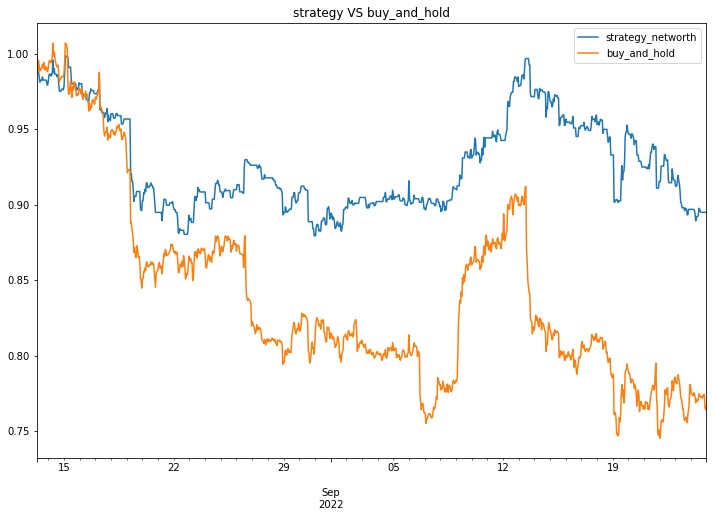

In [371]:
_ = backtestTable[['strategy_networth', 'buy_and_hold']].plot(figsize = (12, 8), title = "strategy VS buy_and_hold")

In [355]:
class backtestMetrics:
    
    def __init__(self, df):
        self.df = df
        self.df_dailyreturn = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        
    def get_return(self):
        return (np.power(self.df.iloc[-1,:]/self.df.iloc[0,:],365*24/self.N) - 1)[0]
    
    def get_vol(self):
        return (np.std(self.df_dailyreturn)*np.sqrt(365*24))[0]
    
    def get_sharpe(self):
        return (self.get_return()/self.get_vol())
    
    def get_cumReturn(self):
        return (self.df.iloc[-1,:]/self.df.iloc[0,:] - 1)[0]
    
    def get_maxdd(self):
        return ((np.maximum.accumulate(self.df) - self.df)/np.maximum.accumulate(self.df)).max()[0]

In [372]:
print("Simple Strategy")
strategyMetrics = backtestMetrics(backtestTable[['strategy_networth']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Annual Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Simple Strategy
Annual Return : -0.6089937251268687
Annual Vol : 0.3676714318397354
Annual Sharpe : -1.656353125070439
Annual Cumulative Return : -0.10405413030762878
Annual Max DD : 0.11960514002303518


In [373]:
print("Buy and Hold")
strategyMetrics = backtestMetrics(backtestTable[['buy_and_hold']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Annual Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Buy and Hold
Annual Return : -0.8959899714650155
Annual Vol : 0.5262643802987188
Annual Sharpe : -1.702547246227139
Annual Cumulative Return : -0.23265825789707006
Annual Max DD : 0.2599409318973026
